# Modelo Gaussiano Acotado

In [1]:
#from numba import jit, cuda

In [2]:
from timeit import default_timer as timer
import time

In [3]:
import numpy as np
import random
from numpy.random import default_rng
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
def svar(h,co,s,a):
    return co + s*(1-np.exp(-(h**2/a**2)))
def Error(gamma,svar):
    return 1/len(svar)*np.sum((svar-gamma)**2)
# svar = lambda h,co,s,a: co + s*(1-np.exp(-(h**2/a**2)))
# error = lambda gamma,svar: 1/len(svar)*np.sum((svar-gamma)**2)


In [5]:
pve =  pd.read_csv(r'C:\Users\drake\OneDrive\Documentos\MCPI\TESIS AJUSTE DE VARIOGRAMA CON MACHING LEARNING\El palmar tesis\Datos completos\datos estandarizados\variograma_exp_errores.csv')
dc = pd.read_csv(r'C:\Users\drake\OneDrive\Documentos\MCPI\TESIS AJUSTE DE VARIOGRAMA CON MACHING LEARNING\El palmar tesis\Datos completos\datos estandarizados\datos_completos_palmar_errores.csv')
matriz_distancias = r'C:\Users\drake\OneDrive\Documentos\MCPI\TESIS AJUSTE DE VARIOGRAMA CON MACHING LEARNING\El palmar tesis\Datos completos\datos estandarizados\matriz_prueba_completos_erroresest.csv'
puntosvariogramaexperimental = pd.read_csv(r'C:\Users\drake\OneDrive\Documentos\MCPI\TESIS AJUSTE DE VARIOGRAMA CON MACHING LEARNING\El palmar tesis\Datos completos\datos estandarizados\variograma_exp_errores.csv')
vardatos = round(dc['Carga_Hidraulica'].var(),2)
dmax = 101096.84
h=np.linspace(0,50549,5000)
print(vardatos)
#e1=0.20
#e2=0.60
#e3=0.20


distancias =  pd.read_csv('matriz_prueba_completos_erroresest.csv')
distancias = distancias.to_numpy()
distancias = distancias[:,1:]
indices=[]
indicestotales=np.arange(309)
for i in range(309):
    ind=distancias[i,:]<10000
    indicest=np.where(ind)[0]
    indices.append(np.delete(indicestotales,indicest))
    indices[i]=np.insert(indices[i],1,i)
# [indices.append(i) for i, x in enumerate(indices) if x]
dc =  dc.to_numpy()    
Z = dc[:,-1]
Z = Z.reshape(len(Z),1)
ZA = np.zeros((len(Z),1))
Ve = np.zeros((len (Z),1))

1.0


In [6]:
def calculo_z(distancias,indices,dc,Z,ZA,Ve,h,co,s,a):         
    svar = None
    error = None
    me = None
    i = 0
    

    while(i<len(distancias)):
        gamma=distancias[:,i]
        gamma= np.delete(gamma,indices[i],axis=0)
        matriz_reducida = np.delete(distancias,indices[i],axis=0)
        matriz_reducida = np.delete(matriz_reducida,indices[i],axis=1)
        sz=matriz_reducida.shape[0]
        # np.savetxt("foo.csv", matriz_reducida, delimiter=",")
        # if i==30:
        #     np.savetxt("foo.csv", matriz_reducida, delimiter=",")
        #     print(matriz_reducida)
        #     dasdadsda
        matriz_reducida = co + s*(1-np.exp(-(matriz_reducida**2/a**2)))
        matriz_reducida = np.concatenate((matriz_reducida, np.ones((1,sz))), axis = 0)
        matriz_reducida = np.concatenate((matriz_reducida, np.ones((sz+1,1))), axis = 1)
        matriz_reducida[-1,-1]=0
        matriz_reducida[matriz_reducida > s] = s
        gamma_l = co + s*(1-np.exp(-(gamma**2/a**2))) 
        gamma_l[gamma_l > s] = s
        gamma = np.c_[gamma_l.reshape(1,sz), 1]
        gamma = gamma.T 
        matriz_reducida = matriz_reducida - np.diag(matriz_reducida) * np.identity(matriz_reducida.shape[0])
        A = np.linalg.inv(matriz_reducida)
        Lamda = np.matmul(A,gamma)
        z = dc[:,-1]
        z= np.delete(z,indices[i],axis=0)
        b = gamma.T
        vee = np.matmul(b,Lamda)
        Ve[i]=vee
        Lamda=Lamda[:-1,:]
        Za=np.dot(z,Lamda)
        ZA[i]= Za 
        i=i+1       
    error = 1/len(Z)*np.sqrt(np.sum((Z-ZA)**2)) 
    error_3 = 1/len(Z)*np.sum(((Z-ZA)**2)/Ve)
    #return (error)
    return (error,error_3) 


In [7]:
def initial_population(size_population,nbits,num_var, verbose=False): 
    """ size_population  = tamaño de la población
       nbists = número de bits de la cadena DNA
    """
    individuos=np.zeros((size_population,nbits,num_var))
    for i in range(size_population):
        for j in range(num_var):
            individuos[i,:,j] = [(random.getrandbits(1)) for number in range(1, nbits+1)]
            if verbose:
                print("Individuo " +str(i+1)+ " variable "+str(j) + ":  " + str(individuos[i,:,j]))     
    return (individuos)

In [8]:
def binatodeci(binary):
    salida=sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))
    return salida

In [9]:
def fitness(distancias,indices,dc,Z,ZA,h,individuos,vardatos,dmax,size_population,nbits,num_var,verbose=False): 
    """ fx        = función a optimizar
       Individuos = población a evaluar
       interval   = [max y min]
    """
    fitness_population=np.zeros((size_population,)) 
    fitness_prob=np.zeros((size_population,)) 
    max_value=(2**nbits-1)
    for i in range(size_population):
        x=np.zeros((num_var,))
        
        x[1]=binatodeci(individuos[i,:,1])
        x[1]= ((vardatos-0)*x[1])/max_value
        x[0]= binatodeci(individuos[i,:,0])
        x[0]= ((x[1]-0)*x[0])/max_value
        x[2]=binatodeci(individuos[i,:,2])
        x[2]= (((dmax/2)-0)*x[2])/max_value
        x[3]= binatodeci(individuos[i,:,3])
        x[3]= 0.2+((0.6*x[3])/max_value)
        x[4]= binatodeci(individuos[i,:,4])
        x[4] = (1-x[3])*(0.2+((0.6*x[4])/max_value))

        error_2 = calculo_z(distancias,indices,dc,Z,ZA,Ve,h,x[0],x[1],x[2])
        #fitness_population[i]=(6*(x[3])*Error(pve.iloc[:,1],svar(pve.iloc[:,0],x[0],x[1],x[2]))) + ((1/6)*(1-x[3])*(error_2))
        fitness_population[i]=(6*(1-x[3]-x[4])*Error(pve.iloc[:,1],svar(pve.iloc[:,0],x[0],x[1],x[2]))) + ((1/6)*(x[3])*(error_2[0])) + ((x[4])*(np.abs(1-error_2[1])))
        #fitness_population[i]=(e1*Error(pve.iloc[:,1],svar(pve.iloc[:,0],x[0],x[1],x[2]))) + ((e2)*(error_2[0])) + ((e3)*(np.abs(1-error_2[1])))
        if verbose:
            print("\n")
            print("Individuo " +str(i+1) +":  " + "   f(x)="+ str(fitness_population[i]))
            print("Pepita: " +str(x[0]))
            print("Meseta: " +str(x[1]))
            print("Alcance: " +str(x[2]))

            
    mini=np.amin(fitness_population)
    ind_mini=np.argmin(fitness_population)
    thebest_individuo=individuos[ind_mini,:,:]
    if verbose:
        print("el mejor individuo: " +str(ind_mini+1))
        
    return fitness_population, thebest_individuo

In [10]:
def selection(fitness_population, individuos,size_population,num_var,selection_method="tournament",verbose=False): 
    """ fitness_population  = Evalaución de la población
       fitness_prob = Evalaución de la población inversa y normalizada  
       metodo_seleccion="tournament"
    """
    selected_population=np.zeros((size_population,nbits,num_var))
    if selection_method == "tournament":
        ind_tournament= [random.randint(0, size_population-1) for i in range(size_population)]
        for i,j in zip(range(size_population),ind_tournament):
            mini= np.argmin([ fitness_population[i],fitness_population[j]])
            if mini==0:
                selected_population[i,:,:]=individuos[i,:,:]
                sel=i
            else:
                selected_population[i,:,:]=individuos[j,:,:]
                sel=j
            if verbose:
                [print("Individuo seleccionado var "+ str(ii)+" : " + str(selected_population[i,:,ii])) for ii in range(num_var)]

                # print("Individuo seleccionado:" +str(np.transpose(selected_population[i,:,:])))    
    return selected_population

In [11]:
def crossover(selected_population, individuos,size_population,nbits,num_var,verbose=False): 
    """ fitness_population  = Evalaución de la población
       fitness_prob = Evalaución de la población inversa y normalizada  
       metodo_seleccion="tournament"
    """
    pointC= [random.randint(1, nbits-2) for i in range(size_population)]
   
    # [print(selected_population[i]) for i in range(size_population)]
    i=0
    cont_int=0
    new_generation=np.zeros((size_population,nbits,num_var))
    rng = default_rng()
    ind_parents=np.zeros((num_var,2))
    parents= np.zeros((2,num_var,nbits))
    for j in range(num_var):
        ind_parents[j,:] = rng.choice(size_population, size=2, replace=False)
        parents[0,j,:]=selected_population[int(ind_parents[j,0]),:,j]
        parents[1,j,:]=selected_population[int(ind_parents[j,1]),:,j]
    for i in range(size_population):
        for j in range(num_var):
            new_generation[i,:,j] =np.concatenate((parents[0,j,0:pointC[i]],parents[1,j,pointC[i]:]))

    if verbose:
        [print("Individuo " + str(i+1)+" seleccionado var: "+ str(ii)+"  " + str(new_generation[i,:,ii])) for ii in range(num_var)]
    i += 1
    
    individuos=new_generation
    
    return individuos

In [12]:
def mutation(individuos,size_population,nbits,num_var, prob_mut=0.02, verbose=False): 
    """ prob  = probabilidad de mutación debe ser baja
    """
    # [print(individuos[ii]) for ii in range(size_population)]
    dat=np.random.uniform(low=0,high=1,size=(size_population,nbits,num_var))<prob_mut
    x,y,z=np.where(dat)
    n_mut= len(x)
    for i,j,k in zip(x,y,z):
        individuos[i,j,k]=1-individuos[i,j,k]
            
    if verbose:
        print("numbers of mutated bits: " + str(n_mut))
    return individuos

In [13]:
#@jit
size_population=32
nbits=12
individuos=initial_population(size_population,nbits,num_var=5,verbose=False)
history=[]
start = time.perf_counter()

for ite in range(600):
    start = time.perf_counter()
    fitness_population,thebest_individuo=fitness(distancias,indices,dc,Z,ZA,h,individuos,vardatos,dmax,size_population,nbits,num_var=5,verbose=False)
    ind_mini=np.argmin(fitness_population)
    history.append(fitness_population[ind_mini])
    selected_population=selection(fitness_population, individuos,size_population,num_var=5,selection_method="tournament",verbose=False)
    individuos=crossover(selected_population, individuos,size_population,nbits,num_var=5,verbose=False)
    individuos=mutation(individuos,size_population,nbits,num_var=5, prob_mut=0.02, verbose=False)
    individuos[0,:,:]=thebest_individuo
    end = time.perf_counter()
    print("Elapsed (with compilation) = {}s".format((end - start)))
    print('iteracion: %5.0f'%ite)
fitness_population,thebest_individuo=fitness(distancias,indices,dc,Z,ZA,h,individuos,vardatos,dmax,size_population,nbits,num_var=5,verbose=False)
ind_mini=np.argmin(fitness_population)
# print(ind_mini)
# print(individuos[ind_mini,:,:])


max_value=(2**nbits-1)
x=np.zeros((5,))
x[1]=binatodeci(individuos[ind_mini,:,1])
x[1]= ((vardatos-0)*x[1])/max_value
x[0]= binatodeci(individuos[ind_mini,:,0])
x[0]= ((x[1]-0)*x[0])/max_value
x[2]=binatodeci(individuos[ind_mini,:,2])
x[2]= (((dmax/2)-0)*x[2])/max_value
x[3]= binatodeci(individuos[ind_mini,:,3])
x[3]= 0.2+((0.6*x[3])/max_value)
x[4]= binatodeci(individuos[ind_mini,:,4])
x[4] = (1-x[3])*(0.2+((0.6*x[4])/max_value))
print(x)
calculo_z(distancias,indices,dc,Z,ZA,Ve,h,x[0],x[1],x[2])


Elapsed (with compilation) = 3.0468942s
iteracion:     0
Elapsed (with compilation) = 2.9047620999999992s
iteracion:     1
Elapsed (with compilation) = 2.9696368s
iteracion:     2
Elapsed (with compilation) = 2.8422526999999995s
iteracion:     3
Elapsed (with compilation) = 2.9137920999999984s
iteracion:     4
Elapsed (with compilation) = 2.8977195999999985s
iteracion:     5
Elapsed (with compilation) = 3.1361725999999983s
iteracion:     6
Elapsed (with compilation) = 2.8151063999999977s
iteracion:     7
Elapsed (with compilation) = 2.8561495999999984s
iteracion:     8
Elapsed (with compilation) = 2.820986999999999s
iteracion:     9
Elapsed (with compilation) = 2.8300971000000033s
iteracion:    10
Elapsed (with compilation) = 2.7980261000000013s
iteracion:    11
Elapsed (with compilation) = 2.9105314000000035s
iteracion:    12
Elapsed (with compilation) = 2.865316700000001s
iteracion:    13
Elapsed (with compilation) = 2.8012986000000026s
iteracion:    14
Elapsed (with compilation) = 2

Elapsed (with compilation) = 3.0637085000000184s
iteracion:   126
Elapsed (with compilation) = 2.9517098000000033s
iteracion:   127
Elapsed (with compilation) = 2.8629958000000215s
iteracion:   128
Elapsed (with compilation) = 3.002085500000021s
iteracion:   129
Elapsed (with compilation) = 2.956507799999997s
iteracion:   130
Elapsed (with compilation) = 3.131543899999997s
iteracion:   131
Elapsed (with compilation) = 3.0922661000000176s
iteracion:   132
Elapsed (with compilation) = 2.946315199999958s
iteracion:   133
Elapsed (with compilation) = 3.0140164000000027s
iteracion:   134
Elapsed (with compilation) = 2.924544400000002s
iteracion:   135
Elapsed (with compilation) = 2.9567377000000192s
iteracion:   136
Elapsed (with compilation) = 3.032579099999964s
iteracion:   137
Elapsed (with compilation) = 2.902190200000007s
iteracion:   138
Elapsed (with compilation) = 2.9505029999999692s
iteracion:   139
Elapsed (with compilation) = 2.9791844000000083s
iteracion:   140
Elapsed (with com

Elapsed (with compilation) = 2.94901219999997s
iteracion:   251
Elapsed (with compilation) = 3.0333362999999736s
iteracion:   252
Elapsed (with compilation) = 3.118680399999903s
iteracion:   253
Elapsed (with compilation) = 3.037144299999909s
iteracion:   254
Elapsed (with compilation) = 3.018834800000036s
iteracion:   255
Elapsed (with compilation) = 2.9083444999999983s
iteracion:   256
Elapsed (with compilation) = 3.016521199999943s
iteracion:   257
Elapsed (with compilation) = 3.095590300000026s
iteracion:   258
Elapsed (with compilation) = 3.0663748000000624s
iteracion:   259
Elapsed (with compilation) = 2.948883599999931s
iteracion:   260
Elapsed (with compilation) = 2.9333277000000635s
iteracion:   261
Elapsed (with compilation) = 2.9492221000000427s
iteracion:   262
Elapsed (with compilation) = 3.075008599999933s
iteracion:   263
Elapsed (with compilation) = 3.0879949000000124s
iteracion:   264
Elapsed (with compilation) = 2.9901698999999553s
iteracion:   265
Elapsed (with compi

Elapsed (with compilation) = 2.892784299999903s
iteracion:   377
Elapsed (with compilation) = 2.904754000000139s
iteracion:   378
Elapsed (with compilation) = 2.879093799999964s
iteracion:   379
Elapsed (with compilation) = 3.0569773999998233s
iteracion:   380
Elapsed (with compilation) = 2.9944970999999896s
iteracion:   381
Elapsed (with compilation) = 2.9518581999998332s
iteracion:   382
Elapsed (with compilation) = 2.848394399999961s
iteracion:   383
Elapsed (with compilation) = 2.8910384999999224s
iteracion:   384
Elapsed (with compilation) = 2.9135367000001224s
iteracion:   385
Elapsed (with compilation) = 3.069430400000101s
iteracion:   386
Elapsed (with compilation) = 2.9357083999998395s
iteracion:   387
Elapsed (with compilation) = 2.89678200000003s
iteracion:   388
Elapsed (with compilation) = 2.806537100000014s
iteracion:   389
Elapsed (with compilation) = 2.823161300000038s
iteracion:   390
Elapsed (with compilation) = 2.9425635999998576s
iteracion:   391
Elapsed (with compi

Elapsed (with compilation) = 3.6352880000001733s
iteracion:   503
Elapsed (with compilation) = 3.3592085000000225s
iteracion:   504
Elapsed (with compilation) = 3.4258770999999797s
iteracion:   505
Elapsed (with compilation) = 3.4040763999998944s
iteracion:   506
Elapsed (with compilation) = 3.544381700000031s
iteracion:   507
Elapsed (with compilation) = 3.466220099999873s
iteracion:   508
Elapsed (with compilation) = 3.0652075000000423s
iteracion:   509
Elapsed (with compilation) = 2.991543899999897s
iteracion:   510
Elapsed (with compilation) = 3.1940442999998595s
iteracion:   511
Elapsed (with compilation) = 3.24981559999992s
iteracion:   512
Elapsed (with compilation) = 3.119363999999905s
iteracion:   513
Elapsed (with compilation) = 3.1056705000000875s
iteracion:   514
Elapsed (with compilation) = 3.144337399999813s
iteracion:   515
Elapsed (with compilation) = 3.122023399999989s
iteracion:   516
Elapsed (with compilation) = 3.234299200000123s
iteracion:   517
Elapsed (with compi

(0.02995598761315104, 0.9999676798726581)

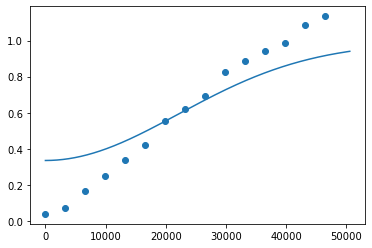

[0.00000000e+00 1.01118224e+01 2.02236447e+01 ... 5.05287764e+04
 5.05388882e+04 5.05490000e+04]
0.025257645874309943


In [14]:
h=np.linspace(0,50549,5000)
b=  x[0] + x[1]*(1-np.exp(-(h**2/x[2]**2)))
plt.scatter(pve.iloc[:,0],pve.iloc[:,1])
plt.plot(h,b)
plt.show()
print(h)
me= x[0] + x[1]*(1-np.exp(-(pve.iloc[:,0]**2/x[2]**2)))
svar = pve.iloc[:,1]
error = 1/len(svar)*np.sum((svar-me)**2)
print(error)

In [15]:
error_z= calculo_z(distancias,indices,dc,Z,ZA,Ve,h,x[0],x[1],x[2])

In [16]:
error_varianza = np.abs(1-error_z[1])
print(error_varianza)

3.232012734188938e-05


In [17]:
error_total=(x[3]*error)+(x[4]*error_z[0])+((1-x[3]-x[4])*(np.abs(1-error_z[1])))

In [18]:
print(error_total)

0.02499999055802797


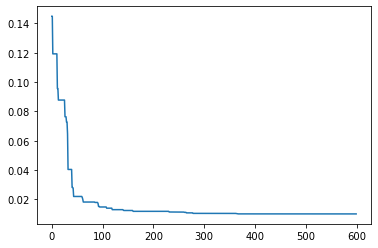

In [19]:
plt.plot(history)

In [20]:
b=np.sqrt(0.07796854802051637)
print(b*119.33)

33.32033536828438
